In [1]:
import sys
import os

In [2]:
sys.path.append(os.getcwd()+'/src/alloyPy')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel as C
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from scipy.optimize import minimize
import itertools
from features import FeatureGenerator

In [4]:
def polt_parity(y_cv_test,y_pred_test, y_cv_train=None,y_pred_train=None, label=None, ylim=[50,900]):
    """
    Function to make parity plots.
    """
    
    # Plot Parity plot
    rmse_test = np.sqrt(mean_squared_error(y_cv_test,y_pred_test))
    r2_test = r2_score(y_cv_test,y_pred_test)
    
    if y_cv_train is None:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharey=True, sharex=True)
    else:
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True, sharex=True)
        
    ax1.scatter(y_cv_test,y_pred_test)
    ax1.text(0.95, 0.26, label, transform=ax1.transAxes, ha='right', fontsize=14)    
    ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_test, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.text(0.95, 0.1, "R$^2$: %.2f"%r2_test, transform=ax1.transAxes, ha='right', fontsize=14)    
    ax1.plot(ylim, ylim, '--k')
    ax1.set_xlabel('True y', fontsize=14)
    ax1.set_ylabel('Pred y', fontsize=14)
    ax1.set_xlim(ylim[0],ylim[1])
    ax1.set_ylim(ylim[0],ylim[1])    
    
    if y_cv_train is not None: 
        rmse_train = np.sqrt(mean_squared_error(y_cv_train,y_pred_train))
        r2_train = r2_score(y_cv_train,y_pred_train)
        
        ax2.scatter(y_cv_train,y_pred_train, c='m')
        ax2.text(0.95, 0.26, "Train", transform=ax2.transAxes, ha='right', fontsize=14)        
        ax2.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax2.transAxes, ha='right', fontsize=14)    
        ax2.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax2.transAxes, ha='right', fontsize=14)        
        ax2.plot(ylim, ylim, '--k')

        ax2.set_xlabel('True y', fontsize=14)    
        ax2.set_xlim(ylim[0],ylim[1])
        ax2.set_ylim(ylim[0],ylim[1])    

    plt.tight_layout()
    plt.show()
    
    return None

In [5]:
data_train = pd.read_csv('training set.csv') 
X = data_train.iloc[:, 1:15]
y = data_train.iloc[0:, 15:16] 


data_test = pd.read_csv('test set.csv') 
xtest = data_test.iloc[:, 1:15]
ytest = data_test.iloc[:, 15:16]

In [6]:
featureGenerator = FeatureGenerator()

# Define elements, functions, and composition
elements = ['Ni', 'Mn', 'Sn', 'Fe', 'Co', 'Cu', 'Al']
functions = ['all']
composition = X.loc[:, ['Ni', 'Mn', 'Sn', 'Fe', 'Co', 'Cu', 'Al']]

# Calculate alloy properties
result_df = featureGenerator.getFeatures(functions,elements, composition)
X=pd.concat([X, result_df], axis=1)

alloyPy 0.0.1 : FeatureGenerator() Initialization successful


In [7]:
Xcols = X.columns
Xcols

Index(['Ni', 'Mn', 'Sn', 'Fe', 'Co', 'Cu', 'Al', 'Numa', 'anum', 'Ven',
       'avg Ven', 'En', 'Arc', 'mass', 'mixing_enthalpy',
       'configurational_entropy', 'weighted_atomicSize_rmsVariation',
       'pairwise_atomicSize_mismatch', 'lambda_parameter',
       'weighted_electronegativity_rmsDeviation',
       'pairwise_electronegativity_mismatch', 'composition_mean_vec',
       'workFunction_parameter', 'composition_mean_cohesiveEnergy',
       'composition_mean_shearModulus', 'weighted_shearModulus_rmsVariation',
       'strengthening_energy_term', 'peierls_nabarro_factor'],
      dtype='object')

In [8]:
X.head()

,Ni,Mn,Sn,Fe,Co,Cu,Al,Numa,anum,Ven,...,lambda_parameter,weighted_electronegativity_rmsDeviation,pairwise_electronegativity_mismatch,composition_mean_vec,workFunction_parameter,composition_mean_cohesiveEnergy,composition_mean_shearModulus,weighted_shearModulus_rmsVariation,strengthening_energy_term,peierls_nabarro_factor
0,41.0,43.0,10.0,0.0,6.0,0.0,0.0,4,28.850,8.050,...,-29.500171,1740.816949,1857.600,805.0,9.680037e+15,365.340,7100.0,-7.431349,-75403.885426,-516.551473
1,49.0,39.0,12.0,0.0,0.0,0.0,0.0,3,29.470,8.110,...,-30.826243,1757.844932,1818.480,811.0,1.014711e+16,369.120,6982.0,-5.753457,-74082.130634,-501.040545
2,43.0,39.0,11.0,0.0,2.0,5.0,0.0,5,29.280,8.200,...,-28.877225,1756.260921,1814.480,820.0,9.879246e+15,365.570,6898.0,-8.721392,-73173.330169,-493.242760
3,42.0,48.0,10.0,0.0,0.0,0.0,0.0,3,28.760,7.960,...,-31.032264,1724.778994,1887.120,796.0,9.145495e+15,358.040,7116.0,-5.728150,-75639.906306,-524.392041
4,43.0,46.0,10.5,0.0,0.0,0.0,0.5,4,28.855,7.955,...,-30.724028,1730.669486,1884.705,795.5,9.302599e+15,359.905,7058.0,-6.398767,-74988.531575,-516.596523


## 5 Fold CV

In [9]:
noise_estimated = 30
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e2))
kernel.k1.constant_value_bounds = (10**-2, 10**7)
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_estimated**2, n_restarts_optimizer=9
)

In [10]:
scaler = StandardScaler()

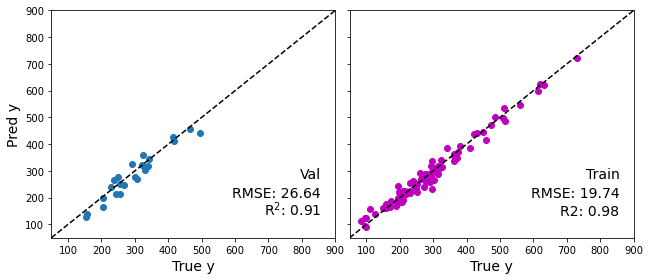

Kernel parameters: 246**2 * RBF(length_scale=5.9)
Root mean squared error: 26.64
Coefficient of determination: 0.91


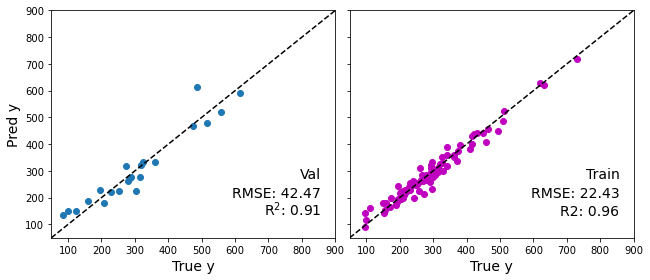

Kernel parameters: 241**2 * RBF(length_scale=6.94)
Root mean squared error: 42.47
Coefficient of determination: 0.91


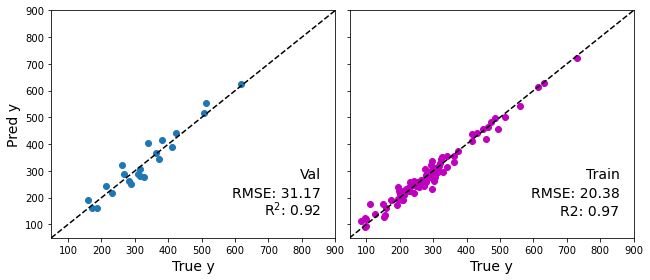

Kernel parameters: 238**2 * RBF(length_scale=6.26)
Root mean squared error: 31.17
Coefficient of determination: 0.92


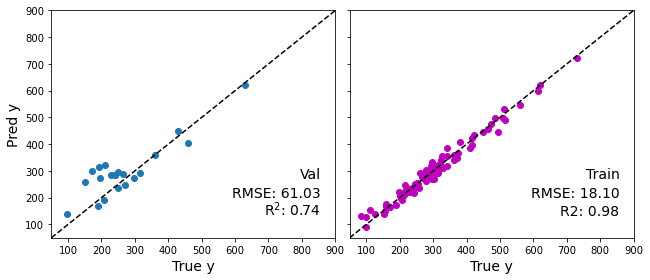

Kernel parameters: 256**2 * RBF(length_scale=6.73)
Root mean squared error: 61.03
Coefficient of determination: 0.74


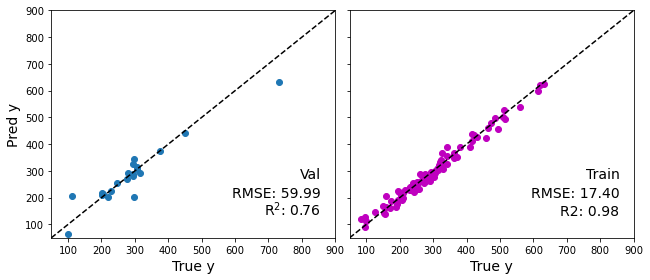

Kernel parameters: 234**2 * RBF(length_scale=5.94)
Root mean squared error: 59.99
Coefficient of determination: 0.76


In [11]:
kf = KFold(n_splits=5)
errors = []
kernels = []
for idx, (train, val) in enumerate(kf.split(X)):
    _X_cv_train = X.values[train]
    _X_cv_val = X.values[val]
    
    X_cv_train = scaler.fit_transform(_X_cv_train)
    X_cv_val = scaler.transform(_X_cv_val)

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]

    # # Normalize the target variable
    # y_cv_train = scaler.fit_transform(y_cv_train.reshape(-1, 1)).flatten()
    # y_cv_val = scaler.transform(y_cv_val.reshape(-1, 1)).flatten()
    
    # Model fit and prediction
    model = gaussian_process.fit(X_cv_train, y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)

    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)
    
    # Plot Parity plot
    polt_parity(y_cv_val, y_pred_val, y_cv_train, y_pred_train, label="Val")

    print("Kernel parameters: %s" % (model.kernel_))
    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val) 
    
    error = {
        'kfold': idx + 1,
        'rmse_train': rmse_train,
        'r2_train': r2_train,
        'rmse_val': rmse_val,
        'r2_val': r2_val
    }

    errors.append(error)
    kernels.append(model.kernel_)


In [12]:
kernels

[246**2 * RBF(length_scale=5.9),
 241**2 * RBF(length_scale=6.94),
 238**2 * RBF(length_scale=6.26),
 256**2 * RBF(length_scale=6.73),
 234**2 * RBF(length_scale=5.94)]

In [13]:
sigma_cs = []
sigma_ls = []

for k in kernels:
    sigma_cs.append(k.k1.constant_value)
    sigma_ls.append(k.k2.length_scale)
k_best = np.median(sigma_cs) * RBF(length_scale=np.median(sigma_ls), length_scale_bounds=(1e-4, 1e2))
k_best.k1.constant_value_bounds = (10**-2, 10**7)

In [14]:
np.median(sigma_cs), np.median(sigma_ls)

(58318.12851090717, 6.257193086423331)

In [15]:
k_best

241**2 * RBF(length_scale=6.26)

In [16]:
errors_gpr_cv_sk_norm = pd.DataFrame(errors)
errors_gpr_cv_sk_norm

,kfold,rmse_train,r2_train,rmse_val,r2_val
0,1,19.742531,0.976051,26.636760,0.907970
1,2,22.427919,0.961389,42.472856,0.911137
2,3,20.380409,0.971506,31.167561,0.923573
3,4,18.101309,0.976925,61.029531,0.739180
4,5,17.397929,0.978806,59.986836,0.763283


In [17]:
errors_gpr_cv_sk_norm[['rmse_val','r2_val']].mean()

rmse_val    44.258709
r2_val       0.849029
dtype: float64

## Optimizing alpha

In [18]:
def run_cv(ml_model, X, y, n_cv = 5):

    kf = KFold(n_splits=n_cv)
    errors = []
    models = []

    for idx, (train, val) in enumerate(kf.split(X)):


        _X_cv_train = X.values[train]
        _X_cv_val = X.values[val]

        mean_train = np.mean(_X_cv_train, axis=0)
        std_train = np.std(_X_cv_train, axis=0)
        X_cv_train = (_X_cv_train - mean_train) / std_train
        X_cv_val = (_X_cv_val - mean_train) / std_train



        y_cv_train = y.values[train]
        y_cv_val = y.values[val]

        # Model fit and prediction
        model = ml_model.fit(X_cv_train, y_cv_train)
        y_pred_val = model.predict(X_cv_val)

        # Computing errors
        rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))

        errors.append(rmse_val)
        models.append(model)

    errors = np.array(errors)

    return np.mean(errors)

In [19]:
alpha_values = np.array([10,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30, 40, 42, 45])**2


def train_gpr_model(X, y, alpha_values):


    cv_results = {'alpha':[], 'cv_rmse':[]}
    for a in alpha_values:
        gaussian_process = GaussianProcessRegressor(
            kernel=k_best, alpha=a, n_restarts_optimizer=3
        )

        cv_error = run_cv(gaussian_process, X, y, n_cv=5)
        cv_results['cv_rmse'].append(cv_error)
        cv_results['alpha'].append(a)

    cv_results = pd.DataFrame(cv_results)
    cv_results = cv_results.sort_values('cv_rmse')
    alpha_opt = cv_results.iloc[0]['alpha']

    print()
    print('Best alpha with lowest CV error:', alpha_opt**0.5)
    print(cv_results)



    gaussian_process = GaussianProcessRegressor(kernel=k_best, alpha=alpha_opt, n_restarts_optimizer=3)
    model = gaussian_process.fit(X, y)

    return model

In [20]:
print(train_gpr_model(X,y,alpha_values))


Best alpha with lowest CV error: 26.0
    alpha    cv_rmse
12    676  44.109826
13    729  44.110442
14    784  44.139011
11    625  44.141443
15    841  44.190229
10    576  44.208212
16    900  44.258712
9     529  44.311259
8     484  44.450442
7     441  44.624531
6     400  44.831543
5     361  45.068945
4     324  45.333792
17   1600  45.433426
3     289  45.622661
18   1764  45.800543
2     256  45.931540
1     225  46.255088
19   2025  46.534515
0     100  47.583416
GaussianProcessRegressor(alpha=676.0, kernel=241**2 * RBF(length_scale=6.26),
                         n_restarts_optimizer=3)


## GPR + Optimized alpha

In [21]:
gaussian_process = GaussianProcessRegressor(kernel=k_best, alpha=26**2)

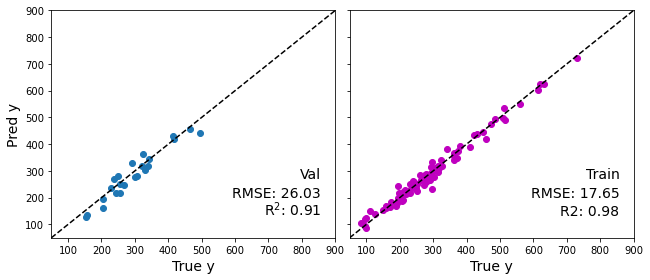

Kernel parameters: 245**2 * RBF(length_scale=5.57)
log marginal likelihood: -468.378
Root mean squared error: 26.03
Coefficient of determination: 0.91


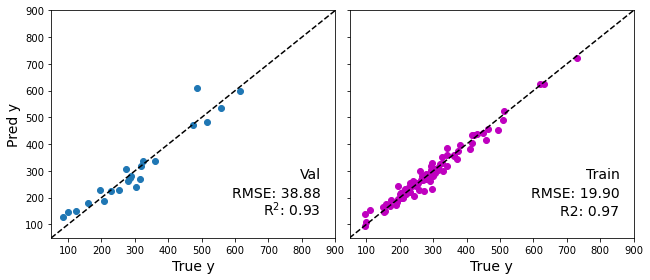

Kernel parameters: 238**2 * RBF(length_scale=6.29)
log marginal likelihood: -471.509
Root mean squared error: 38.88
Coefficient of determination: 0.93


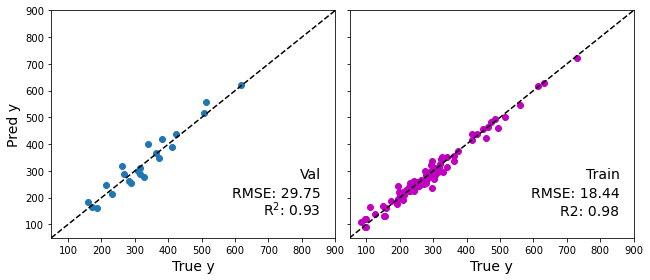

Kernel parameters: 236**2 * RBF(length_scale=5.89)
log marginal likelihood: -472.112
Root mean squared error: 29.75
Coefficient of determination: 0.93


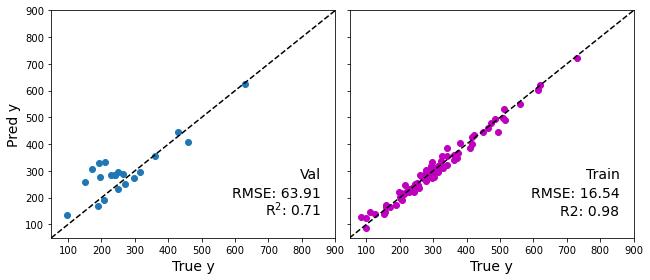

Kernel parameters: 259**2 * RBF(length_scale=6.54)
log marginal likelihood: -463.388
Root mean squared error: 63.91
Coefficient of determination: 0.71


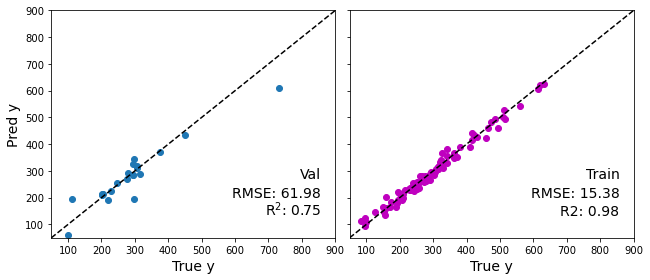

Kernel parameters: 232**2 * RBF(length_scale=5.66)
log marginal likelihood: -469.522
Root mean squared error: 61.98
Coefficient of determination: 0.75


In [22]:
kf = KFold(n_splits=5)

errors = []
kernels = []

for idx, (train, val) in enumerate(kf.split(X)):
    _X_cv_train = X.values[train]
    _X_cv_val = X.values[val]
    
    X_cv_train = scaler.fit_transform(_X_cv_train)
    X_cv_val = scaler.transform(_X_cv_val)
    
    y_cv_train = y.values[train]
    y_cv_val = y.values[val]
    
    
    # Model fit and prediction
    model = gaussian_process.fit(X_cv_train, y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    mse_val = mean_squared_error(y_cv_val, y_pred_val)
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)
    
    
    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Kernel parameters: %s"%(model.kernel_))
    print("log marginal likelihood: %.3f" %model.log_marginal_likelihood_value_)
    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val) 
    
    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,             
             'rmse_val': rmse_val,
             'r2_val': r2_val,
             'mse_val': mse_val
            }

    errors.append(error)
    kernels.append(model.kernel_)

In [23]:
errors_gpr_cv_opt_alpha = pd.DataFrame(errors)
errors_gpr_cv_opt_alpha.mean()

kfold            3.000000
rmse_train      17.579430
r2_train         0.978267
rmse_val        44.109884
r2_val           0.845857
mse_val       2200.049472
dtype: float64

In [24]:
np.sqrt(errors_gpr_cv_opt_alpha['mse_val'].mean())

46.904684965379715

In [25]:
k_best

241**2 * RBF(length_scale=6.26)

In [26]:
sigma_cs = []
sigma_ls = []

print("Previous k_best: ", k_best)

for k in kernels:
    sigma_cs.append(k.k1.constant_value)
    sigma_ls.append(k.k2.length_scale)
k_opt = np.median(sigma_cs) * RBF(length_scale=np.median(sigma_ls), length_scale_bounds=(1e-6, 1e2))
k_opt.k1.constant_value_bounds = (10**-2, 10**7)

print("New k_best: ", k_opt)

Previous k_best:  241**2 * RBF(length_scale=6.26)
New k_best:  238**2 * RBF(length_scale=5.89)


## RFE CV

In [27]:
gaussian_process = GaussianProcessRegressor(
    kernel=k_opt, alpha=26**2, n_restarts_optimizer=3
)

In [28]:
def run_cv(ml_model, X, y, n_cv = 5):

    kf = KFold(n_splits=n_cv)
    errors = []
    models = []

    for idx, (train, val) in enumerate(kf.split(X)):


        _X_cv_train = X.values[train]
        _X_cv_val = X.values[val]

        mean_train = np.mean(_X_cv_train, axis=0)
        std_train = np.std(_X_cv_train, axis=0)
        X_cv_train = (_X_cv_train - mean_train) / std_train
        X_cv_val = (_X_cv_val - mean_train) / std_train



        y_cv_train = y.values[train]
        y_cv_val = y.values[val]

        # Model fit and prediction
        model = ml_model.fit(X_cv_train, y_cv_train)
        y_pred_val = model.predict(X_cv_val)

        # Computing errors
        rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))

        errors.append(rmse_val)
        models.append(model)

    errors = np.array(errors)

    return np.mean(errors)

In [29]:
# Greedy selection of features with minimum CV RMSE

current_Xcols = Xcols
rfe_results = {"rmse_cv":[], "sel_cols":[]}
for rfe_run_idx in range(26):

    _rmse_cvs = []
    for rm_idx, rm_col in enumerate(current_Xcols):
        _Xcols = current_Xcols.drop(rm_col)

        # Get CV error for this set
        _rmse_cv = run_cv(gaussian_process, X[_Xcols], y)
        _rmse_cvs.append(_rmse_cv)

    _rmse_cvs = np.array(_rmse_cvs)

    worst_col = current_Xcols[np.argmin(_rmse_cvs)]
    print("Worst column %s" %worst_col)
    print("RFE RMSE CV %.2f" %np.min(_rmse_cvs))
    current_Xcols = current_Xcols.drop(worst_col)
    rfe_results["rmse_cv"].append(np.min(_rmse_cvs))
    rfe_results["sel_cols"].append(current_Xcols)

Worst column weighted_atomicSize_rmsVariation
RFE RMSE CV 39.55
Worst column Fe
RFE RMSE CV 38.53
Worst column weighted_shearModulus_rmsVariation
RFE RMSE CV 37.50
Worst column configurational_entropy
RFE RMSE CV 36.30
Worst column lambda_parameter
RFE RMSE CV 34.61
Worst column Al
RFE RMSE CV 34.11
Worst column avg Ven
RFE RMSE CV 33.71
Worst column Ven
RFE RMSE CV 33.27
Worst column composition_mean_vec
RFE RMSE CV 32.67
Worst column Arc
RFE RMSE CV 32.25
Worst column Ni
RFE RMSE CV 31.94
Worst column composition_mean_shearModulus
RFE RMSE CV 31.63
Worst column Sn
RFE RMSE CV 31.43
Worst column workFunction_parameter
RFE RMSE CV 31.16
Worst column strengthening_energy_term
RFE RMSE CV 30.82
Worst column composition_mean_cohesiveEnergy
RFE RMSE CV 30.61
Worst column mass
RFE RMSE CV 30.27
Worst column anum
RFE RMSE CV 30.26
Worst column peierls_nabarro_factor
RFE RMSE CV 30.45
Worst column Mn
RFE RMSE CV 30.52
Worst column weighted_electronegativity_rmsDeviation
RFE RMSE CV 31.49
Wors

C:\Users\Harisankar\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Worst column Numa
RFE RMSE CV 44.60


C:\Users\Harisankar\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Harisankar\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Worst column mixing_enthalpy
RFE RMSE CV 97.83


In [30]:
# rfe_results['sel_cols'][np.argmin(rfe_results['rmse_cv'])]

In [31]:
n_features= len(Xcols) - np.arange(len(rfe_results["rmse_cv"])) - 1 

In [32]:
min_idx = np.argmin(rfe_results["rmse_cv"])
rmse = rfe_results["rmse_cv"][min_idx]

sel_features = rfe_results["sel_cols"][min_idx]
sel_features

Index(['Mn', 'Co', 'Cu', 'Numa', 'En', 'mixing_enthalpy',
       'pairwise_atomicSize_mismatch',
       'weighted_electronegativity_rmsDeviation',
       'pairwise_electronegativity_mismatch', 'peierls_nabarro_factor'],
      dtype='object')

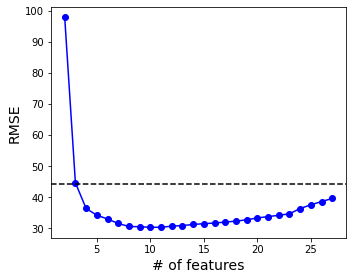

In [33]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax1.plot(n_features, rfe_results["rmse_cv"], '-bo')
ax1.axhline(errors_gpr_cv_opt_alpha['rmse_val'].mean(), linestyle='--', color='k')
#ax1.set_ylim(70,100)
ax1.set_xlabel('# of features', fontsize=14)
ax1.set_ylabel('RMSE', fontsize=14)
plt.tight_layout()

In [34]:
print("Initial number of features", len(Xcols))
print("Selected number of features", len(sel_features))

Initial number of features 28
Selected number of features 10


In [35]:
print("Mean square error with RFE (eV^2): ", rmse)

Mean square error with RFE (eV^2):  30.25962826355921


In [36]:
X2 = X[sel_features]
X2

,Mn,Co,Cu,Numa,En,mixing_enthalpy,pairwise_atomicSize_mismatch,weighted_electronegativity_rmsDeviation,pairwise_electronegativity_mismatch,peierls_nabarro_factor
0,43.00,6.0,0.0,4,1.75840,-74881.600,100.389180,1740.816949,1857.6000,-516.551473
1,39.00,0.0,0.0,3,1.77560,-75127.200,109.053180,1757.844932,1818.4800,-501.040545
2,39.00,2.0,5.0,5,1.77400,-62045.200,104.731020,1756.260921,1814.4800,-493.242760
3,48.00,0.0,0.0,3,1.74220,-79036.800,99.317520,1724.778994,1887.1200,-524.392041
4,46.00,0.0,0.0,4,1.74815,-81439.000,102.417665,1730.669486,1884.7050,-516.596523
...,...,...,...,...,...,...,...,...,...,...
106,47.50,0.0,0.0,3,1.74425,-78848.700,101.464020,1726.808495,1889.4750,-521.029412
107,38.15,6.0,0.0,5,1.77513,-70363.548,103.722548,1757.379601,1804.6744,-507.071396
108,37.00,0.0,0.0,3,1.78330,-73435.600,113.124000,1765.467913,1791.4200,-493.228795
109,45.00,0.0,0.0,3,1.75050,-79810.000,77.700000,1732.995952,1829.5000,-546.125461


## Optimization after RFE

In [37]:
alpha_values = np.array([10,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30, 40, 42, 45])**2


print(train_gpr_model(X2,y,alpha_values))


Best alpha with lowest CV error: 18.0
    alpha    cv_rmse
4     324  28.951968
3     289  28.965717
5     361  28.986198
2     256  29.036477
6     400  29.062826
7     441  29.178267
1     225  29.179275
8     484  29.330039
9     529  29.516196
10    576  29.734789
11    625  29.983607
12    676  30.259657
13    729  30.559121
14    784  30.876981
15    841  31.207618
16    900  31.545160
0     100  32.862144
17   1600  34.709836
18   1764  35.291414
19   2025  36.168155
GaussianProcessRegressor(alpha=324.0, kernel=241**2 * RBF(length_scale=6.26),
                         n_restarts_optimizer=3)


C:\Users\Harisankar\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [38]:
gaussian_process = GaussianProcessRegressor(kernel=k_opt, alpha=18**2)

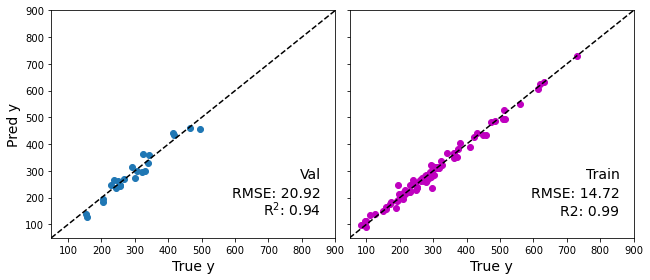

Kernel parameters: 281**2 * RBF(length_scale=2.93)
log marginal likelihood: -468.484
Root mean squared error: 20.92
Coefficient of determination: 0.94


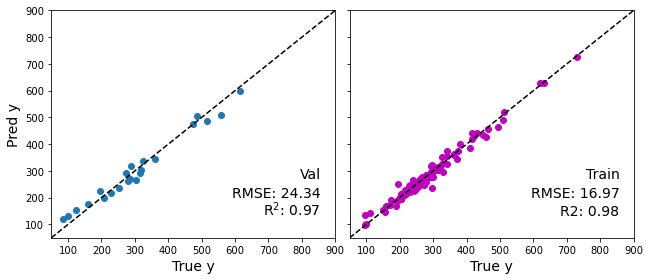

Kernel parameters: 279**2 * RBF(length_scale=3.37)
log marginal likelihood: -471.605
Root mean squared error: 24.34
Coefficient of determination: 0.97


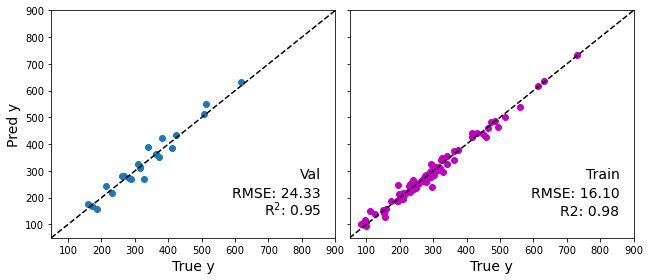

Kernel parameters: 296**2 * RBF(length_scale=3.26)
log marginal likelihood: -472.533
Root mean squared error: 24.33
Coefficient of determination: 0.95


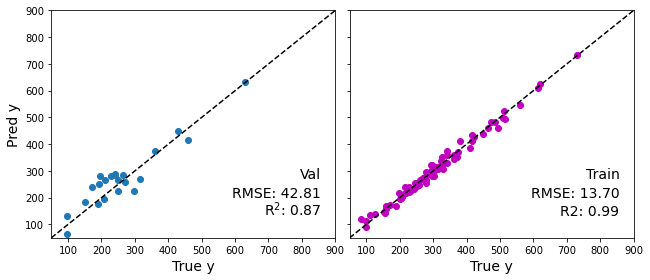

Kernel parameters: 283**2 * RBF(length_scale=3.37)
log marginal likelihood: -459.015
Root mean squared error: 42.81
Coefficient of determination: 0.87


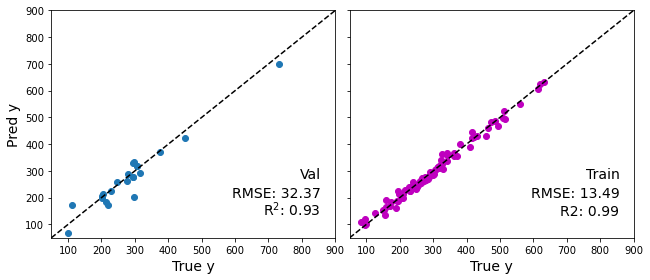

Kernel parameters: 277**2 * RBF(length_scale=3.11)
log marginal likelihood: -463.775
Root mean squared error: 32.37
Coefficient of determination: 0.93


In [39]:
kf = KFold(n_splits=5)

errors = []
kernels = []

for idx, (train, val) in enumerate(kf.split(X2)):
    _X_cv_train = X2.values[train]
    _X_cv_val = X2.values[val]
    
    X_cv_train = scaler.fit_transform(_X_cv_train)
    X_cv_val = scaler.transform(_X_cv_val)

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]
    
    
    # Model fit and prediction
    model = gaussian_process.fit(X_cv_train, y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    mse_val = mean_squared_error(y_cv_val, y_pred_val)
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)
    
    
    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Kernel parameters: %s"%(model.kernel_))
    print("log marginal likelihood: %.3f" %model.log_marginal_likelihood_value_)
    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val) 
    
    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,             
             'rmse_val': rmse_val,
             'r2_val': r2_val,
             'mse_val': mse_val
            }

    errors.append(error)
    kernels.append(model.kernel_)

In [40]:
errors_gpr_cv_opt_alpha2 = pd.DataFrame(errors)
errors_gpr_cv_opt_alpha2.mean()

kfold           3.000000
rmse_train     14.994752
r2_train        0.984170
rmse_val       28.951947
r2_val          0.934051
mse_val       900.367763
dtype: float64

## Full set

In [41]:
X2_scaled = scaler.fit_transform(X2)
model = gaussian_process.fit(X2_scaled,y)
print()
print(model.kernel_, model.kernel)


278**2 * RBF(length_scale=3.17) 238**2 * RBF(length_scale=5.89)


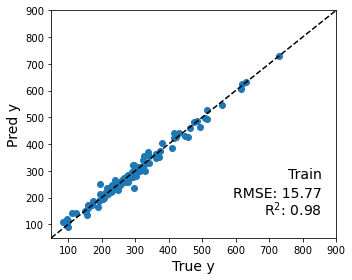

Kernel parameters: 278**2 * RBF(length_scale=3.17)
Root mean squared error: 15.77
Coefficient of determination: 0.98


In [42]:
y_pred = model.predict(X2_scaled)


rmse_train = np.sqrt(mean_squared_error(y, y_pred))
r2_train = r2_score(y, y_pred)

# Plot Parity plot
polt_parity(y,y_pred,label="Train")

print("Kernel parameters: %s"%(model.kernel_))
print("Root mean squared error: %.2f" % rmse_train)
print("Coefficient of determination: %.2f" % r2_train) 


In [43]:
elements = ['Ni', 'Mn', 'Sn', 'Fe', 'Co', 'Cu', 'Al']
functions = ['all']
composition = xtest.loc[:, ['Ni', 'Mn', 'Sn', 'Fe', 'Co', 'Cu', 'Al']]

# Calculate alloy properties
result_df = featureGenerator.getFeatures(functions,elements, composition)
xtest=pd.concat([xtest, result_df], axis=1)

In [44]:
xtest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Ni                                       5 non-null      float64
 1   Mn                                       5 non-null      float64
 2   Sn                                       5 non-null      float64
 3   Fe                                       5 non-null      int64  
 4   Co                                       5 non-null      int64  
 5   Cu                                       5 non-null      float64
 6   Al                                       5 non-null      int64  
 7   Numa                                     5 non-null      int64  
 8   anum                                     5 non-null      float64
 9   Ven                                      5 non-null      float64
 10  avg Ven                                  5 non-null   

In [45]:
X3 = xtest[sel_features]
X3

,Mn,Co,Cu,Numa,En,mixing_enthalpy,pairwise_atomicSize_mismatch,weighted_electronegativity_rmsDeviation,pairwise_electronegativity_mismatch,peierls_nabarro_factor
0,36.5,0,0.0,3,1.78535,-72919.900,115.108500,1767.497408,1785.5550,-490.042674
1,46.0,0,0.0,4,1.74640,-84420.400,100.920680,1728.936983,1882.6800,-516.983895
2,35.9,0,4.5,4,1.78746,-61858.836,118.085146,1769.586301,1781.5408,-474.037478
3,39.0,0,0.0,4,1.77110,-67960.400,105.362500,1753.389908,1824.3800,-510.101010
4,41.0,1,0.0,4,1.76610,-76859.200,91.774200,1748.439933,1816.3000,-524.300763


In [46]:
col = X3.columns

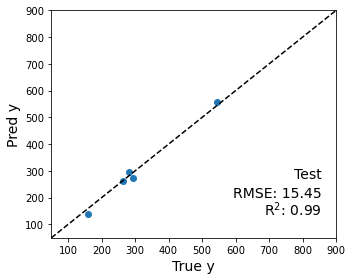

Kernel parameters: 278**2 * RBF(length_scale=3.17)
Root mean squared error: 15.45
Coefficient of determination: 0.985234


In [47]:
X2_cv_train = scaler.fit_transform(X2)
X2_cv_train = pd.DataFrame(X2_cv_train,columns = col)
X3_cv_val = scaler.transform(X3)
X3_cv_val = pd.DataFrame(X3_cv_val,columns=col)
model = gaussian_process.fit(X2_cv_train,y)
ypred = model.predict(X3_cv_val)
rmse_test = np.sqrt(mean_squared_error(ytest, ypred))
r2_test = r2_score(ytest, ypred)

# Plot Parity plot
polt_parity(ytest,ypred,label="Test")

print("Kernel parameters: %s"%(model.kernel_))
print("Root mean squared error: %.2f" % rmse_test)
print("Coefficient of determination: %.6f" % r2_test) 

In [48]:
r2_test

0.9852342962294892

In [49]:
test_pre = pd.concat([data_test.loc[:, ['NiMn']], ytest, pd.DataFrame(ypred)], axis=1)
test_pre.rename(columns={'T': 'True', 0: 'predict'}, inplace=True)
test_pre

,NiMn,True,predict
0,Ni50Mn36.5Sn13.5,282.0,295.432711
1,Ni43Mn46Sn10Al1,262.5,260.641820
2,Ni45.3Mn35.9Cu4.5Sn14.3,159.0,139.544422
3,Ni45Mn39Fe5Sn11,295.0,274.279840
4,Ni50Mn41Sn8Co1,544.0,558.194935


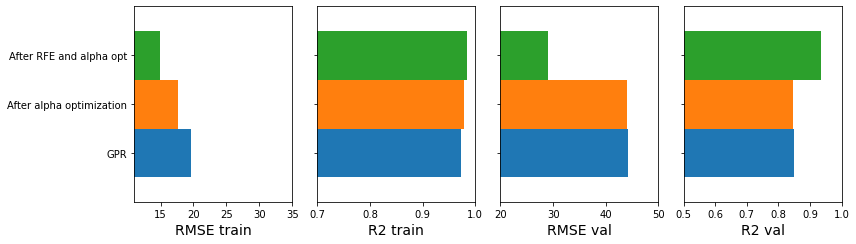

In [50]:
width = 0.1
labels = ['GPR','After alpha optimization','After RFE and alpha opt']
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12,3.5), sharey=True)
    
for idx,e in enumerate([errors_gpr_cv_sk_norm,errors_gpr_cv_opt_alpha, errors_gpr_cv_opt_alpha2]):
    rmse_test = e.mean()['rmse_val']
    r2_test = e.mean()['r2_val']
    rmse_train = e.mean()['rmse_train']
    r2_train = e.mean()['r2_train']
    
    ax3.barh(0 + width*(idx-1), rmse_test, height=width, label=labels[idx], align='center')
    ax4.barh(0 + width*(idx-1), r2_test, height=width, label=labels[idx], align='center')
    ax1.barh(0 + width*(idx-1), rmse_train, height=width, label=labels[idx], align='center')
    ax2.barh(0 + width*(idx-1), r2_train, height=width, label=labels[idx], align='center')    
    
ax3.set_xlabel('RMSE val', fontsize=14)
ax4.set_xlabel('R2 val', fontsize=14)
ax1.set_xlabel('RMSE train', fontsize=14)
ax2.set_xlabel('R2 train', fontsize=14)  

ax1.set_yticks([-0.1,0,0.1])
ax1.set_yticklabels(labels)

ax1.set_ylim(-0.2,0.2)
ax3.set_xlim(20,50)
ax4.set_xlim(0.5,1)
ax1.set_xlim(11,35)
ax2.set_xlim(0.7,1)

plt.tight_layout()
plt.show()

In [51]:
import shap 

In [52]:
X2_scaled = pd.DataFrame(X2_scaled,columns = col)

In [53]:
X2_scaled

,Mn,Co,Cu,Numa,En,mixing_enthalpy,pairwise_atomicSize_mismatch,weighted_electronegativity_rmsDeviation,pairwise_electronegativity_mismatch,peierls_nabarro_factor
0,0.243515,1.601002,-0.348965,0.449951,-0.272476,-0.289504,-0.171648,-0.269991,0.617346,-0.306075
1,-0.463711,-0.595676,-0.348965,-1.272274,0.547296,-0.327503,0.569688,0.550876,-0.088816,0.518746
2,-0.463711,0.136550,2.585511,2.172175,0.471038,1.696549,0.199862,0.474516,-0.161021,0.933406
3,1.127549,-0.595676,-0.348965,-1.272274,-1.044587,-0.932398,-0.263344,-1.043131,1.150217,-0.723010
4,0.773935,-0.595676,-0.348965,0.449951,-0.761003,-1.304067,0.001920,-0.759168,1.106623,-0.308470
...,...,...,...,...,...,...,...,...,...,...
106,1.039145,-0.595676,-0.348965,-1.272274,-0.946881,-0.903295,-0.079679,-0.945295,1.192728,-0.544197
107,-0.613997,1.601002,-0.348965,2.172175,0.524895,0.409531,0.113572,0.528444,-0.338024,0.198045
108,-0.817325,-0.595676,-0.348965,-1.272274,0.914287,-0.065778,0.918008,0.918356,-0.577281,0.934149
109,0.597129,-0.595676,-0.348965,-1.272274,-0.648999,-1.052028,-2.113049,-0.647017,0.110108,-1.878722


ExactExplainer explainer: 112it [00:37,  2.17it/s]                                                                     


Text(-938.5833333333334, 0.5, 'Feature')

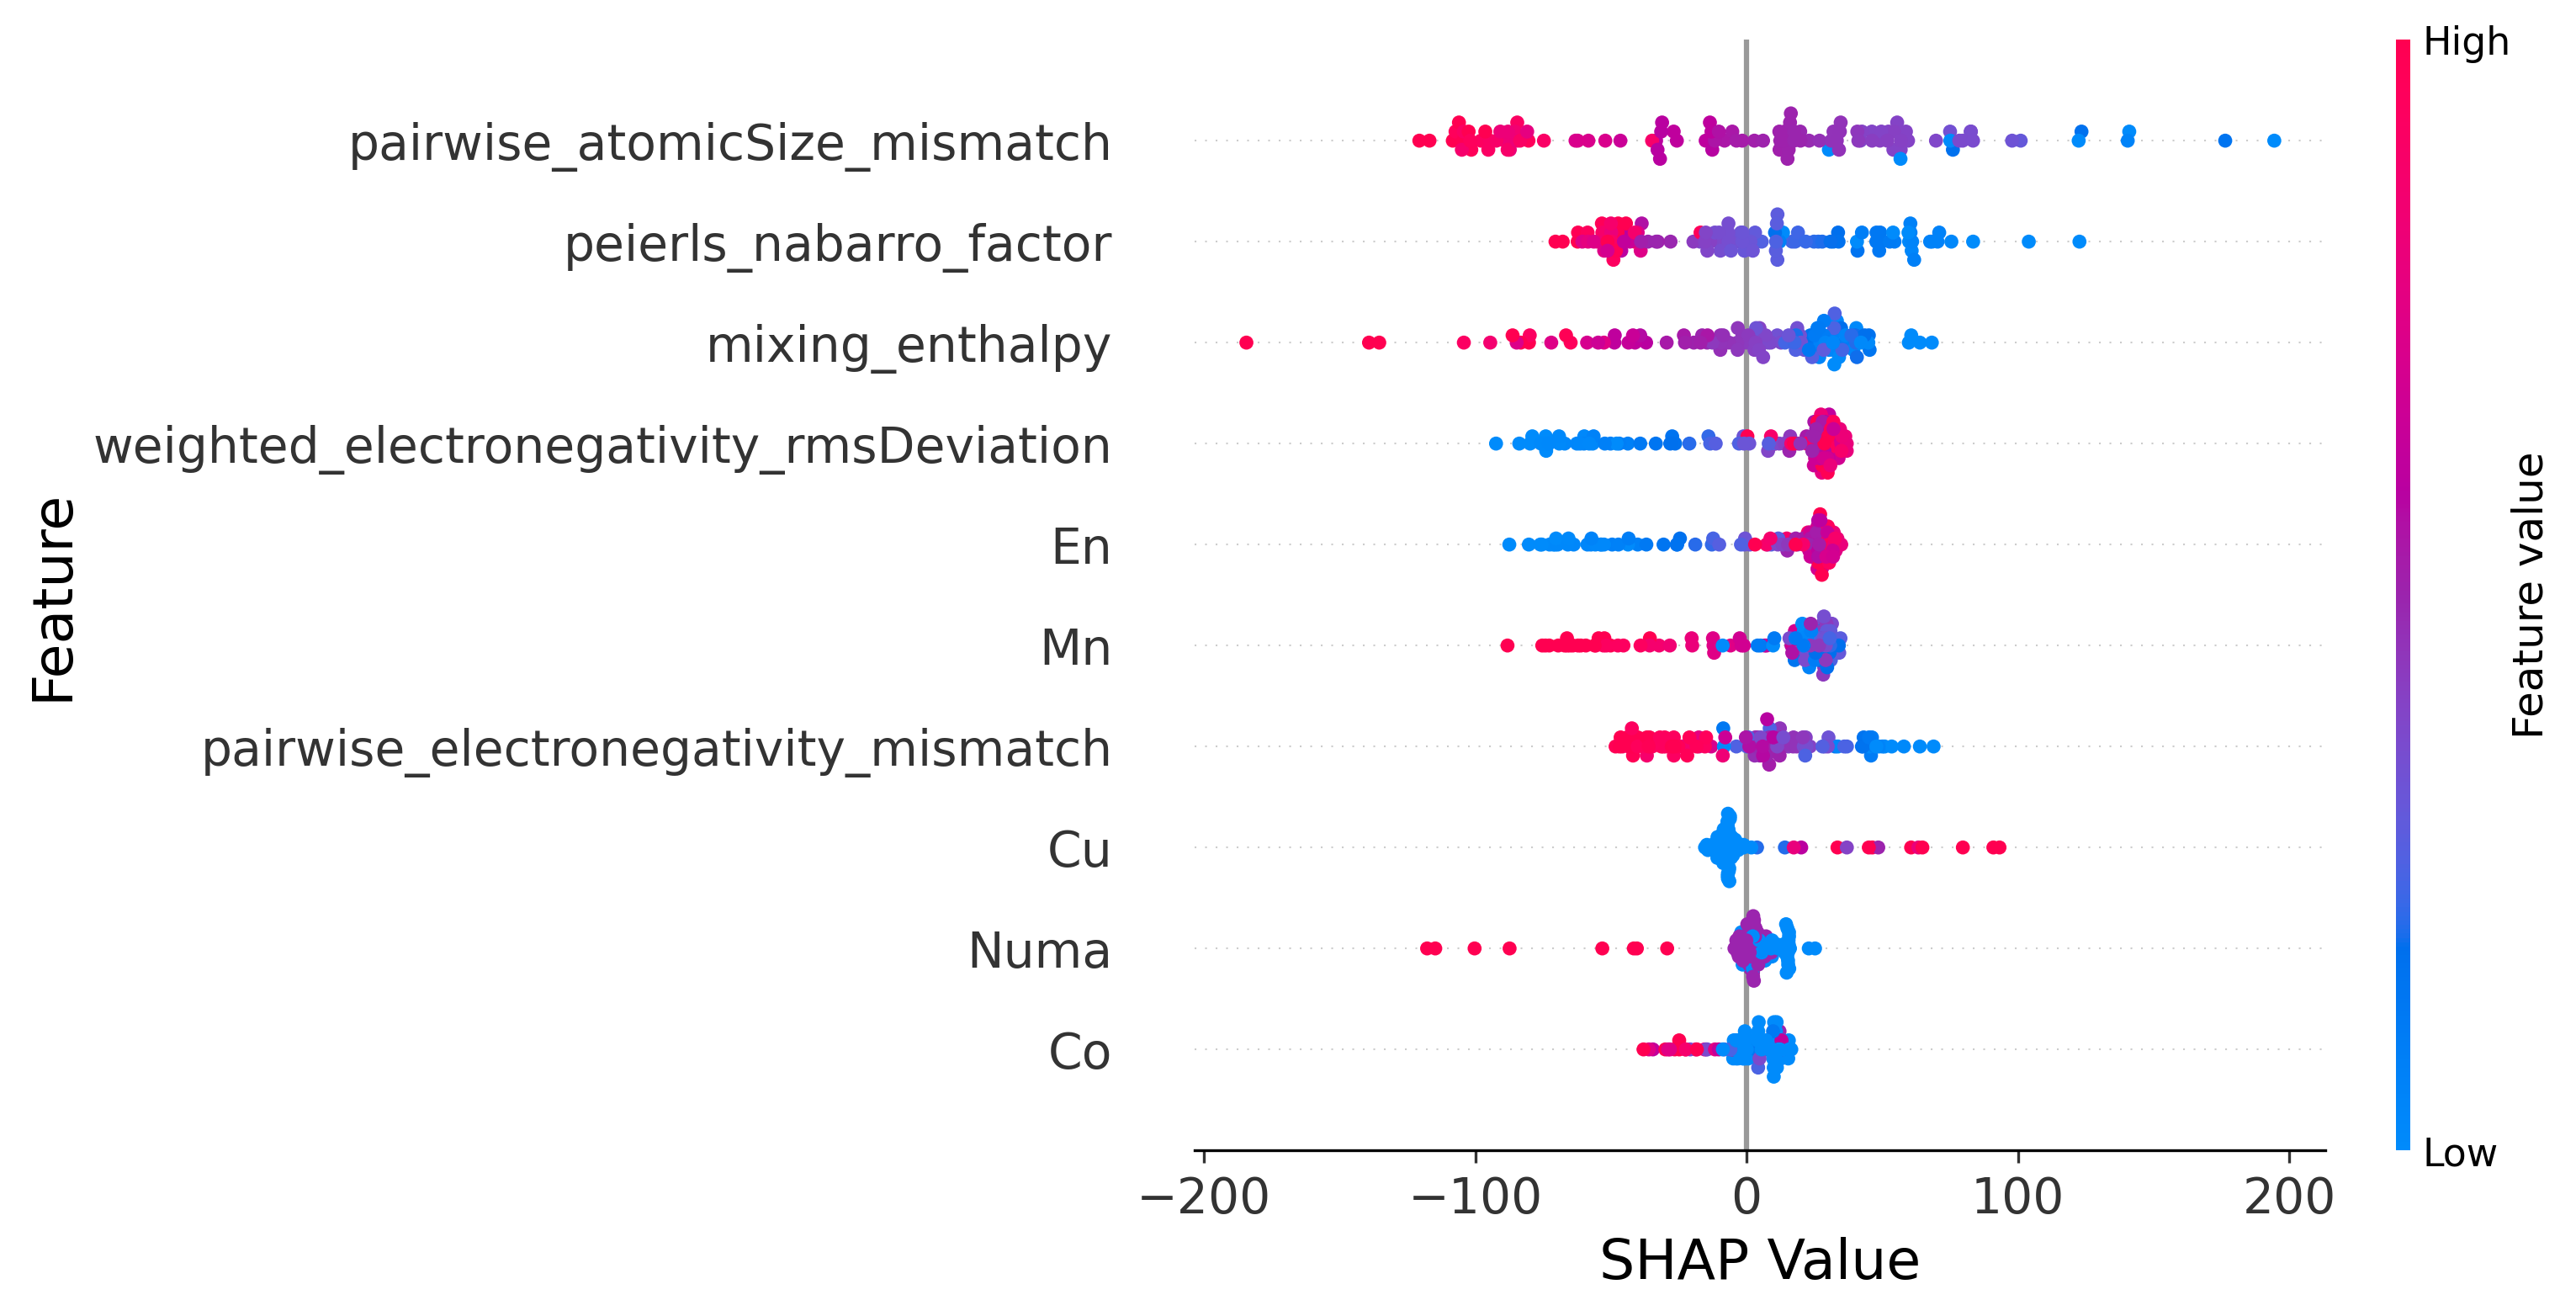

In [63]:
explainer = shap.Explainer(model.predict,X2_scaled)
shap_values = explainer(X2_scaled)


plt.clf
plt.figure(figsize=(12, 8), dpi=300)  # Set the figure size and resolution
shap.plots.beeswarm(shap_values, show=False)

# Adjust the plot settings for better clarity
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)  # Adjust the subplot margins
plt.tick_params(labelsize=14)  # Increase the tick label font size
plt.xlabel('SHAP Value', fontsize=16)  # Set the x-axis label and font size
plt.ylabel('Feature', fontsize=16)  # Set the y-axis label and font size

In [67]:
plt.savefig('C:/Users/Harisankar/my python stuff/alloyFeatureLibrary/beeswarm_plot.png', dpi=300, bbox_inches='tight')
#plt.show()

<Figure size 432x288 with 0 Axes>

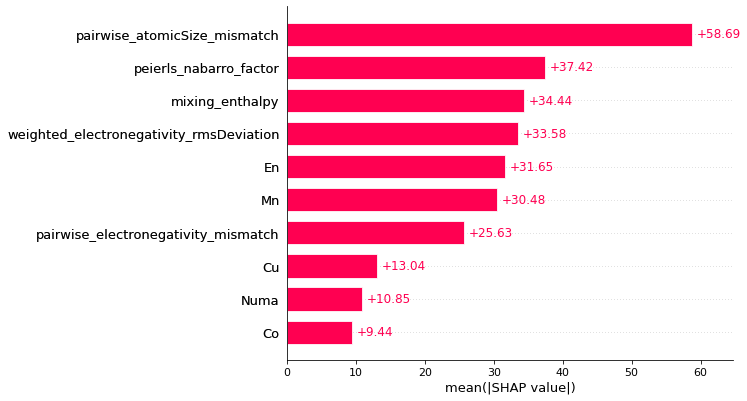

In [57]:
shap.plots.bar(shap_values,show = False)